In [1]:
import numpy as np
import pandas as pd
import re

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle

In [2]:
items = pd.read_csv('../data/items_t.csv')
shops = pd.read_csv('../data/shops_t.csv')
cats = pd.read_csv('../data/item_categories_t.csv')
train = pd.read_csv('../data/sales_train.csv')
test = pd.read_csv('../data/test.csv').set_index('ID')

In [ ]:
display(items.head())
display(shops.head())
display(cats.head())
display(train.head())
display(test.head())

In [ ]:
train.shape

In [ ]:
train.drop_duplicates(subset=['date','date_block_num','shop_id','item_id','item_cnt_day'], inplace=True)
train.shape

In [ ]:
train.describe()

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [ ]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [ ]:
train[train['item_price']<0]

In [ ]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [ ]:
shops[shops['Name'].duplicated()]

In [ ]:
shops[shops['Name']=='Chkalov Str. 39 m2']

In [ ]:
shops[shops['City']=='Novosibirsk']

In [ ]:
shops[shops['City']=='Omsk']

In [ ]:
shops[shops['City']=='Rostov-on-Don']

In [ ]:
shops[shops['City']=='Khimki']

In [ ]:
shops[shops['City']=='Yakutsk']

In [ ]:
# Ordzhonikidze, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Central
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Chkalov Str. 39 m2
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
items.head()

In [ ]:
item_names = items.item_name.values
p = re.compile(r'\((.*?)\)', re.S)
features = []
for o in item_names:
    features.append(re.findall(p, o)[-2:])
features[:5]

In [ ]:
item_f1 = []
item_f2 = []

for o in features:
    if len(o) == 0:
        item_f1.append(np.nan)
        item_f2.append(np.nan)
    elif len(o) == 1:
        item_f1.append(o[0])
        item_f2.append(np.nan)
    else:
        item_f1.append(o[1])
        item_f2.append(o[0])

In [ ]:
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.int16)
items.head()

In [ ]:
items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], axis=1, inplace=True)
items.head()

In [ ]:
shops.head()

In [ ]:
shops['city_code'] = LabelEncoder().fit_transform(shops['City'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['Type'])
shops = shops[['shop_id','city_code','shop_type_code']]
shops.head()

In [ ]:
cats.head()

In [ ]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

cats.head()

In [ ]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [ ]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [ ]:
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

In [ ]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f1_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f1_avg_item_cnt')
matrix.drop(['date_cat_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f2_code'], how='left')
matrix['date_cat_item_f2_avg_item_cnt'] = matrix['date_cat_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f2_avg_item_cnt')
matrix.drop(['date_cat_item_f2_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_type_code'], how='left')
matrix['date_item_shop_type_avg_item_cnt'] = matrix['date_item_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_shop_type_avg_item_cnt')
matrix.drop(['date_item_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f1_code'], how='left')
matrix['date_subtype_item_f1_avg_item_cnt'] = matrix['date_subtype_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f1_avg_item_cnt')
matrix.drop(['date_subtype_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f2_code'], how='left')
matrix['date_subtype_item_f2_avg_item_cnt'] = matrix['date_subtype_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f2_avg_item_cnt')
matrix.drop(['date_subtype_item_f2_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [ ]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num


In [ ]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

In [ ]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [ ]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

matrix = downcast_dtypes(matrix)

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [3]:
data = pd.read_pickle('data.pkl')

In [4]:
data = data[data['date_block_num']>11]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 49 columns):
date_block_num                             int8
item_cnt_month                             float16
item_id                                    int16
shop_id                                    int8
city_code                                  int8
shop_type_code                             int8
item_category_id                           int8
item_f1_code                               int16
item_f2_code                               int16
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                       float16
item_cnt_month_lag_2                       float16
item_cnt_month_lag_3                       float16
item_cnt_month_lag_6                       float16
item_cnt_month_lag_12                      float16
date_avg_item_cnt_lag_1                    float16
date_item_avg_item_cnt_lag_1            

In [6]:
data.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,...,date_subtype_item_f1_avg_item_cnt_lag_1,date_subtype_item_f2_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,0.0,27,2,0,4,19,1136,255,9,...,1.125977,1.050781,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,0.0,30,2,0,4,40,1136,255,3,...,0.398682,0.290771,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,0.0,31,2,0,4,37,390,255,3,...,0.227783,0.233887,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,1.0,32,2,0,4,40,1136,255,3,...,0.398682,0.290771,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,1.0,33,2,0,4,37,390,255,3,...,0.227783,0.233887,-0.225464,1.211914,0,31,1,1,12,12


In [7]:
data = data[[
    'date_block_num',
    'item_cnt_month',
    'item_id',                     
    'shop_id',                        
    'city_code',                         
    'shop_type_code',             
    'item_category_id',                         
    'item_f1_code',         
    'item_f2_code',                  
    'type_code',                      
    'subtype_code',                            
    'item_cnt_month_lag_1',                   
    'item_cnt_month_lag_2',            
    'item_cnt_month_lag_3',                  
    'item_cnt_month_lag_6',                  
    'item_cnt_month_lag_12',                
    'date_avg_item_cnt_lag_1',               
    'date_item_avg_item_cnt_lag_1',         
    'date_item_avg_item_cnt_lag_2',         
    'date_item_avg_item_cnt_lag_3',         
    'date_item_avg_item_cnt_lag_6',         
    'date_item_avg_item_cnt_lag_12',       
    'date_shop_avg_item_cnt_lag_1',        
    'date_shop_avg_item_cnt_lag_2',        
    'date_shop_avg_item_cnt_lag_3',        
    'date_shop_avg_item_cnt_lag_6',        
    'date_shop_avg_item_cnt_lag_12',      
    'date_cat_avg_item_cnt_lag_1',          
    'date_cat_item_f1_avg_item_cnt_lag_1', 
    'date_cat_item_f2_avg_item_cnt_lag_1', 
    'date_shop_cat_avg_item_cnt_lag_1',    
    #'date_shop_type_avg_item_cnt_lag_1_x',        
    'date_shop_subtype_avg_item_cnt_lag_1',       
    'date_city_avg_item_cnt_lag_1',               
    #'date_shop_type_avg_item_cnt_lag_1_y',      
    'date_item_city_avg_item_cnt_lag_1',       
    'date_item_shop_type_avg_item_cnt_lag_1',    
    #'date_type_avg_item_cnt_lag_1',         
    #'date_subtype_avg_item_cnt_lag_1',     
    'date_subtype_item_f1_avg_item_cnt_lag_1',
    'date_subtype_item_f2_avg_item_cnt_lag_1',    
    'delta_price_lag',                      
    'delta_revenue_lag_1',                    
    'month',                                    
    'days',                                       
    'item_shop_last_sale',                     
    'item_last_sale',                            
    'item_shop_first_sale',                    
    'item_first_sale',
]]                           


In [8]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

data = downcast_dtypes(data)

In [9]:
data = data[data['date_block_num']>11]

In [11]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [12]:
del data

In [13]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    sub_sample=0.8,
    eta=0.3,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds=10)

C:\Users\g9016\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\g9016\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:28:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:51] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.14971	validation_1-rmse:1.11427
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10044	validation_1-rmse:1.07581
[2]	validation_0-rmse:1.0579	validation_1-rmse:1.04408
[3]	validation_0-rmse:1.02176	validation_1-rmse:1.01601
[4]	validation_0-rmse:0.991103	validation_1-rmse:0.993093
[5]	validation_0-rmse:0.965113	validation_1-rmse:0.975409
[6]	validation_0-rmse:0.943301	validation_1-rmse:0.959943
[7]	validation_0-rmse:0.92437

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=300, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, sub_sample=0.8, subsample=1, verbosity=1)

In [16]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission191120.csv', index=False)


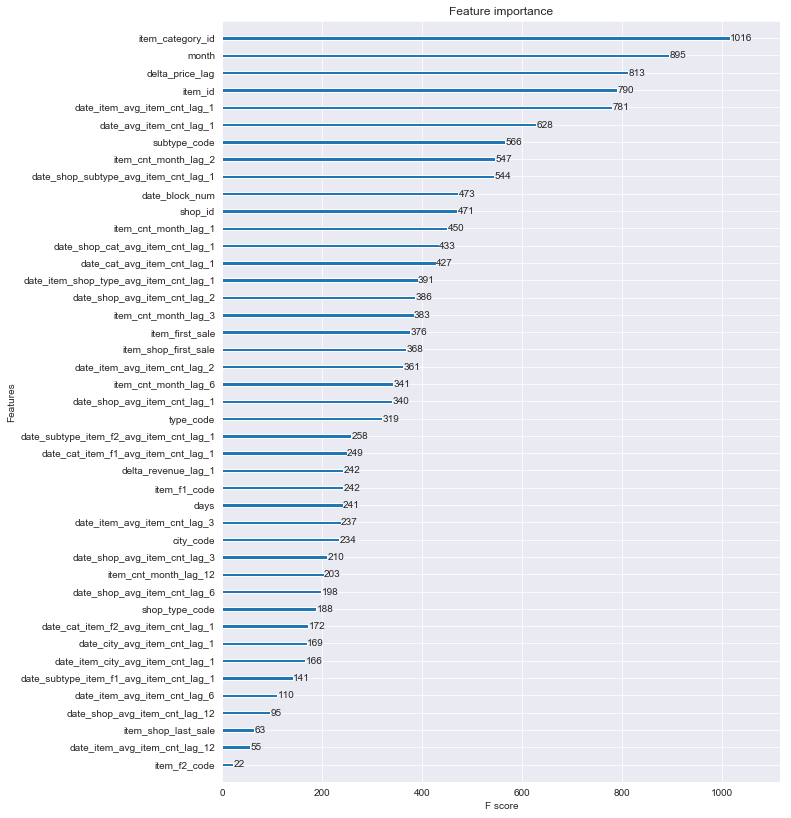

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,14))
plot_importance(model, ax=ax)

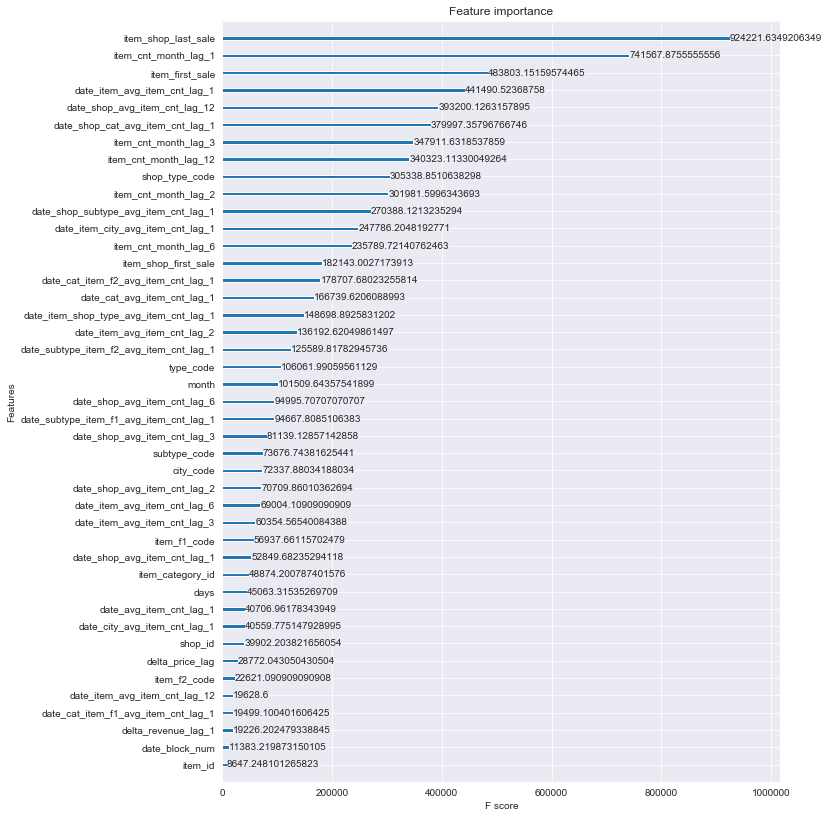

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,14))
plot_importance(model, ax=ax, importance_type="cover")

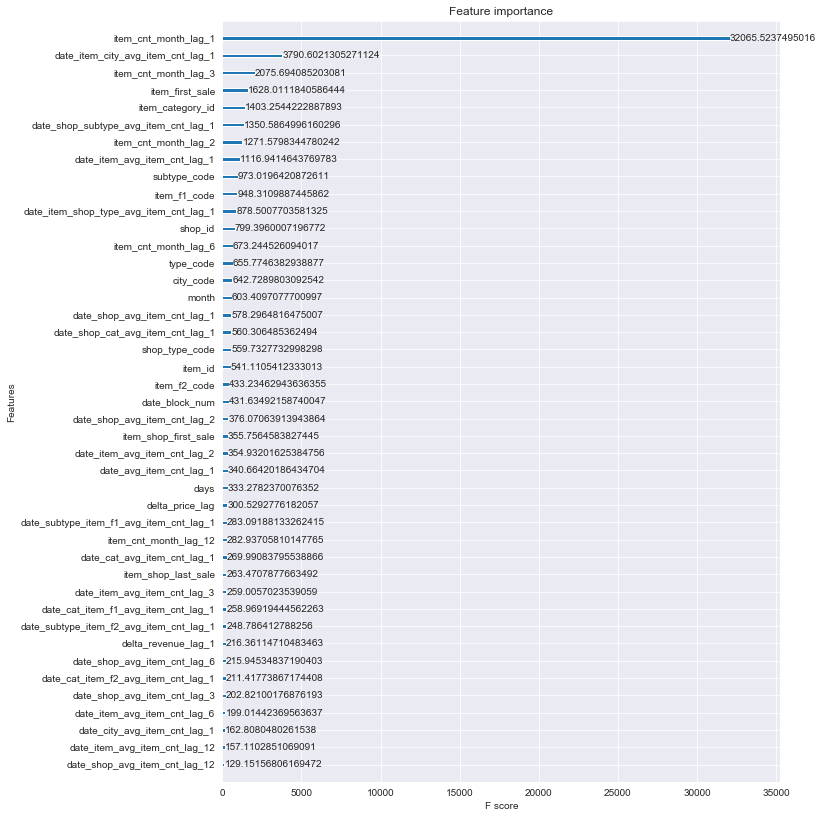

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,14))
plot_importance(model, ax=ax, importance_type="gain")